<a href="https://colab.research.google.com/github/haifaamara/student-performance-analysis/blob/main/My_Second_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Performance**

Haifa Amara


We are going to examine the factors influencing academic student performance in order to derive actionable insights for this model.

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant

from google.colab import files
uploaded = files.upload()


Saving Student_Performance.csv to Student_Performance.csv


In [ ]:
# Load the uploaded dataset
data = pd.read_csv('Student_Performance.csv')

# Display the first few rows of the dataset
data.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91
1,4,82,No,4,2,65
2,8,51,Yes,7,2,45
3,5,52,Yes,5,2,36
4,7,75,No,8,5,66


# Data Context:
* **Hours Studied:** The total number of hours spent studying by each student.
* **Previous Scores:** The scores obtained by students in previous tests.
* **Extracurricular Activities:** Whether the student participates in extracurricular activities (Yes or No).
* **Sleep Hours:** The average number of hours of sleep the student had per day.
* **Sample Question Papers Practiced:** The number of sample question papers the student practiced.
* **Performance Index:** A measure of the overall performance of each student.
 It is the target variable. *The index ranges from 10 to 100, with higher values indicating better performance.*

---



In [ ]:
# Check for null values
print(data.isnull().sum().sort_values(ascending=False).head(10))

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64


In [ ]:
# Drop columns with too many missing values
missing_threshold = 0.3  # 30% threshold
cols_to_drop = data.columns[data.isnull().mean() > missing_threshold]
data = data.drop(columns=cols_to_drop)

# Impute missing values for numerical columns with the median
for col in data.select_dtypes(include='number').columns:
    data[col].fillna(data[col].median(), inplace=True)

# Impute missing values for categorical columns with the mode
for col in data.select_dtypes(include='object').columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Exploratory Data Analysis (EDA)
data.describe()

<ipython-input-10-cb668742517f>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-10-cb668742517f>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


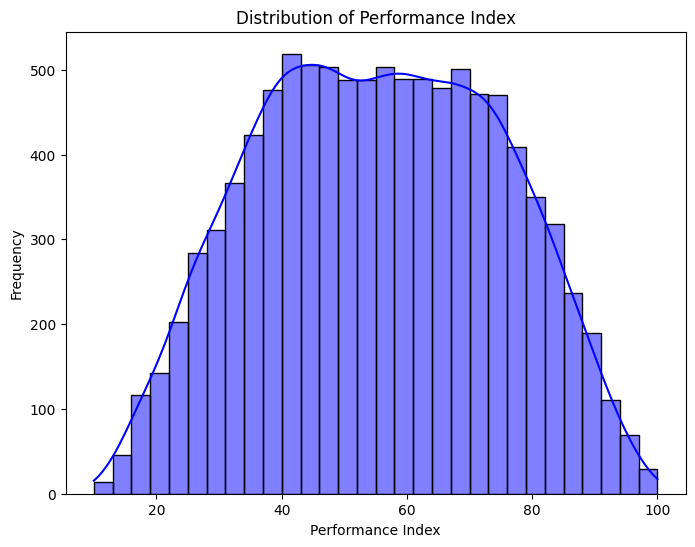

In [ ]:
# Visualizing the target variable (SalePrice)
plt.figure(figsize=(8, 6))
sns.histplot(data['Performance Index'], kde=True, bins=30, color='blue')
plt.title('Distribution of Performance Index')
plt.xlabel('Performance Index')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

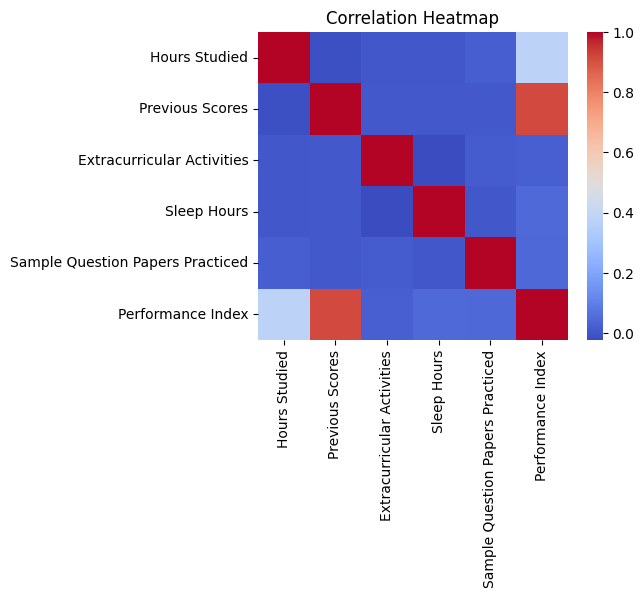

In [ ]:
# Correlation heatmap
plt.figure(figsize=(5, 4))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Selecting features for regression
# Use only numerical columns and drop those with very low correlation with the target
correlation_with_target = data.corr()['Performance Index'].sort_values(ascending=False)
print(correlation_with_target)

Performance Index                   1.000000
Previous Scores                     0.915189
Hours Studied                       0.373730
Sleep Hours                         0.048106
Sample Question Papers Practiced    0.043268
Extracurricular Activities          0.024525
Name: Performance Index, dtype: float64


In [ ]:
# Selecting top correlated features for regression
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index.tolist()
selected_features.remove('Performance Index')  # Exclude the target variable
print("Selected Features:", selected_features)

Selected Features: ['Previous Scores', 'Hours Studied']


'Previous Scores' and 'Hours Studied' are the features with an absolute correlation greater than 0.2 with 'Performance Index' (your target variable).

# **Assumptions of Linear Regression**
- **Linearity**

The relationship between predictors and the target variable should be linear.


- **Independence of Errors**

Residuals should be independent of each other (no autocorrelation).

- **Homoscedasticity**

The variance of residuals should be constant across all levels of the independent variables.

- **Normality of Residuals**

The residuals should be approximately normally distributed.

- **No Multicollinearity**

Independent variables should not be highly correlated with each other.

# Linearity

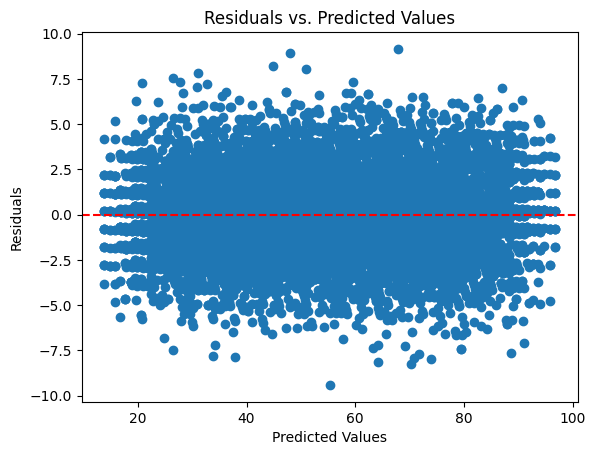

In [ ]:
# Independent and dependent variables
import statsmodels.api as sm

X = data[['Previous Scores', 'Hours Studied']]
y = data['Performance Index']

# Add a constant for the intercept
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Now, when making predictions, use the same features:
predictions = model.predict(X)
residuals = y - predictions

plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

 The plot suggests no clear pattern, meaning the model likely meets the linearity assumption and is a **good fit for a linear regression model**.


# Independence of Errors

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(model.resid)
print("Durbin-Watson statistic:", dw)

Durbin-Watson statistic: 1.9922442320929137


Values close to 2 indicate **no autocorrelation**.

# Homoscedasticity
**Test:** Plot residuals versus predicted values. Homoscedasticity is satisfied if the residuals have constant variance (no funnel shape).
Alternatively, perform the **Breusch-Pagan test:**

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X)
print("Breusch-Pagan p-value:", bp_test[1])

Breusch-Pagan p-value: 0.8906696796869428


A Breusch-Pagan p-value of 0.891 indicates that we fail to reject the null hypothesis of homoscedasticity. This means **there is no significant evidence of heteroscedasticity in the model**, and the residuals likely have constant variance.

# Normality of Residuals
**Test:** Check residuals with a histogram or Q-Q plot.
**Test:** Perform the Shapiro-Wilk test

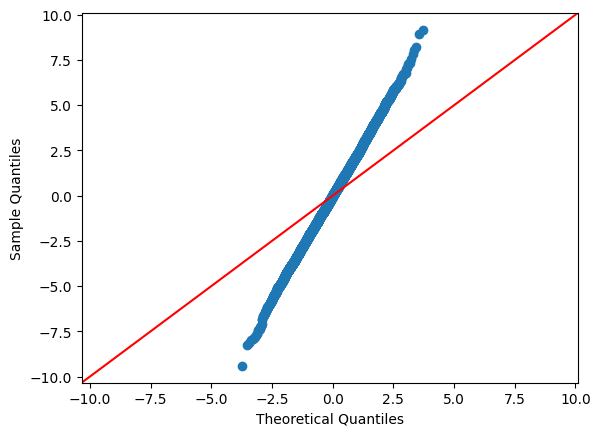

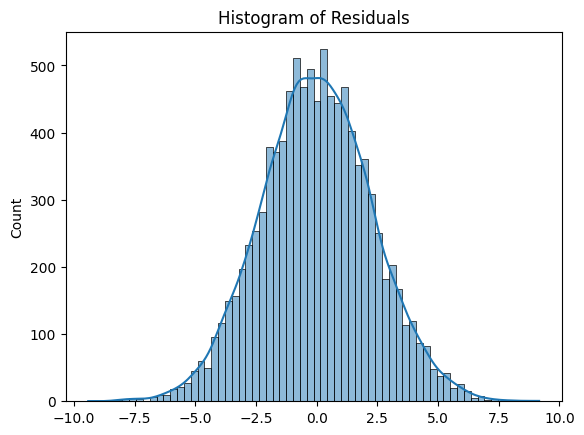

In [ ]:
sm.qqplot(residuals, line='45')
plt.show()

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

In [ ]:
from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)

Shapiro-Wilk p-value: 0.6287476845324954


A p-value > 0.05 indicates **normality**.

# Multicollinearity
Test: Calculate the Variance Inflation Factor (VIF). VIF > 10 indicates multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

          Variable        VIF
0            const  20.948366
1  Previous Scores   1.000154
2    Hours Studied   1.000154


**Summary of Assumptions:**
* Linearity: Met.
* Homoscedasticity: No significant evidence of violation.
* Normality: Violated; residuals deviate significantly from normality.
* Independence of Errors: No autocorrelation.
* Multicollinearity: No significant issues.

# **Modeling**

In [ ]:
# Splitting data into training and testing sets
X = data[selected_features]
y = data['Performance Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Building and evaluating a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predictions and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 5.24
R-squared (R²): 0.99


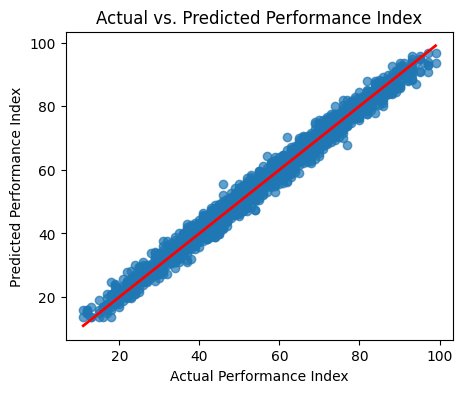

In [ ]:
# Visualizing actual vs. predicted prices
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('Actual vs. Predicted Performance Index')
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')
plt.show()

In [ ]:
# Running an OLS regression for more detailed diagnostics
X_train_with_const = add_constant(X_train)
ols_model = OLS(y_train, X_train_with_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Performance Index   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.790e+05
Date:                Wed, 29 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:05:19   Log-Likelihood:                -17953.
No. Observations:                8000   AIC:                         3.591e+04
Df Residuals:                    7997   BIC:                         3.593e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -29.6703      0.117   -2

performance index= 0-29.6703 +(Previous Scores×1.0174)+(Hours Studied×2.8582)

In [ ]:
# Interpreting feature importance
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print(coefficients)

           Feature  Coefficient
1    Hours Studied     2.858155
0  Previous Scores     1.017372


## **1. Model Fit**

* **R-squared** (0.986): Approximately 98.6% of the variance in the dependent variable (Performance Index) is explained by the model.
* **Adjusted R-squared** (0.986): After adjusting for the number of predictors, the model still explains 98.6% of the variance, indicating a good fit.It is close to R-squared suggesting that adding more predictors wouldn’t significantly improve the model.
* **F-statistic** (2.790e+05): The model is statistically significant as a whole, with a null p-value, suggesting that the predictors collectively have a significant effect on Performance Index.

## **2. Coefficients**

* **const** (-29.6703): This is the intercept. When all independent variables are zero, the predicted SalePrice is approximately 14.59 units.
* **Previous Scores** (1.0174): For every increase in previous scores, the SalePrice increases by approximately 1.0174, holding other variables constant. This variable has a null p-value, indicating a statistically significant positive impact.
* **Hours Studied** (2.8582): For every additional hour studied, the Performance Index increases by approximately 2.8582, holding other variables constant. This variable has a null p-value, indicating a statistically significant positive impact.


## **3. Significance**

All predictors have p-values < 0.05, indicating that they are statistically significant.
The confidence intervals ([0.025, 0.975]) for all coefficients do not include zero, further confirming significance.

## **4. Residual Diagnostics**

* **Durbin-Watson** (2.029): Suggests no strong autocorrelation in residuals.
* **Jarque-Bera** (JB) = 1.461, **Prob**(JB) = 0.482: residuals don't follow a normal distribution.
* **Condition Number** (329) : Indicates low multicollinearity, as it’s below 1000.

## **5. Model Selection Metrics**

**AIC** (3.591e+04) and **BIC** (3.593e+04): Lower values of these metrics indicate better model fit. These metrics can be used to compare this model with others.

## **Enhacing normality with transformation**

**Box-Cox transformation**: A flexible family of transformations that finds the best power transformation for normality.

Optimal Lambda: 0.2744389257460641
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8009
Date:                Thu, 30 Jan 2025   Prob (F-statistic):              0.452
Time:                        19:03:02   Log-Likelihood:                -175.32
No. Observations:                 100   AIC:                             356.6
Df Residuals:                      97   BIC:                             364.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

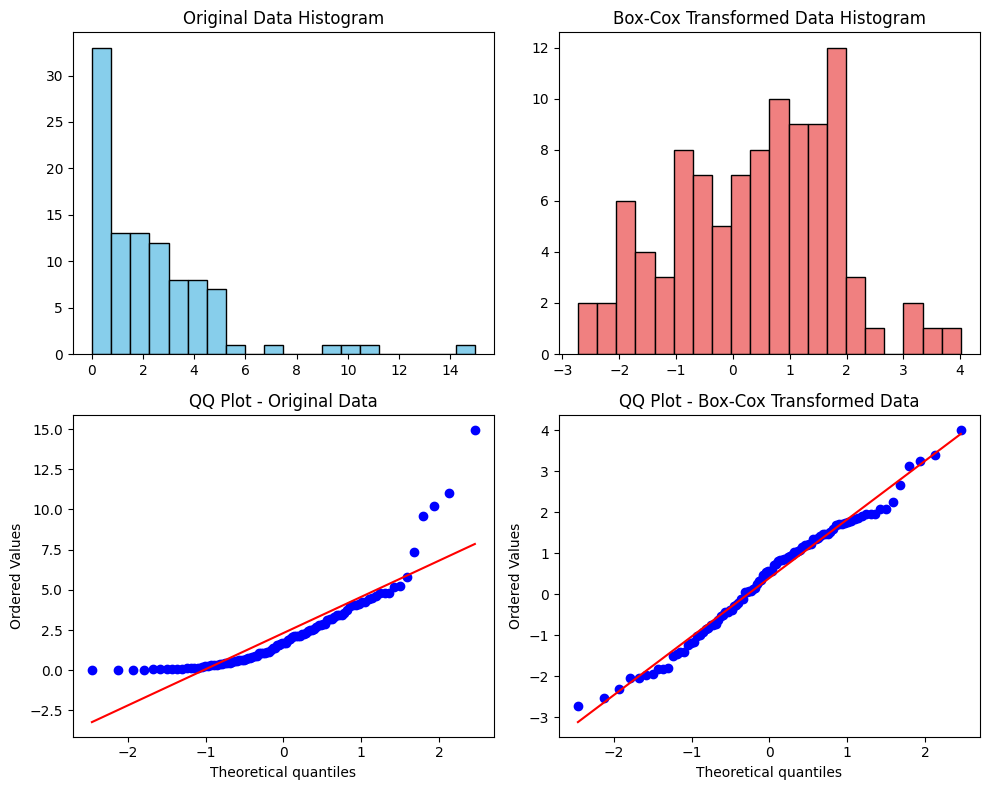

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Example data (must be positive)
data = np.random.exponential(scale=2, size=100)  # Right-skewed data
X = np.random.rand(100, 2)  # Random independent variables
X = sm.add_constant(X)  # Add intercept

# Apply Box-Cox transformation
y_transformed, lambda_value = stats.boxcox(data)

print(f"Optimal Lambda: {lambda_value}")

# Fit linear regression model
model = sm.OLS(y_transformed, X).fit()
print(model.summary())

# Plot original vs transformed data
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].hist(data, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title("Original Data Histogram")
axes[0, 1].hist(y_transformed, bins=20, color='lightcoral', edgecolor='black')
axes[0, 1].set_title("Box-Cox Transformed Data Histogram")

# QQ plots
stats.probplot(data, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title("QQ Plot - Original Data")
stats.probplot(y_transformed, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("QQ Plot - Box-Cox Transformed Data")

plt.tight_layout()
plt.show()

performance index= 0.7752 +(Previous Scores×-0.5658)+(Hours Studied×-0.2065)

# Business Insights from the Analysis

## **Key Factors Influencing Student Performance**
* **Previous Scores**:
Students with higher previous scores tend to perform better. For every 1-point increase in previous scores, the performance index rises by approximately 1.02 units.

➡ *Recommendation*: Highlight the importance of building a strong academic foundation. Schools and tutors can use this insight to design personalized learning programs for students based on their past performance.

* **Hours Studied**:
The number of hours a student studies has a strong positive impact on performance. Each additional hour of study increases the performance index by 2.86 units.

➡ *Recommendation*: Encourage students to adopt structured study routines. Educational institutions can promote study schedules and provide time management resources to help students optimize their study habits.

* **Interaction of Previous Scores & Study Hours**:
Students who already have high previous scores may benefit less from additional study hours compared to those with lower previous scores. This suggests a diminishing return on study time for top-performing students.

➡ *Recommendation*: Tailor study plans based on students' starting performance levels. High-achievers might benefit from more advanced problem-solving sessions, while others may need foundational reinforcement.

# Prediction Model

In [ ]:
# Train the Model
import pandas as pd
import statsmodels.api as sm

# Sample training data (replace this with your actual dataset)
data = {
    "Previous Scores": [70, 85, 90, 60, 75, 95],
    "Hours Studied": [5, 10, 8, 3, 6, 12],
    "Performance Index": [72, 88, 91, 58, 78, 97]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Define features and target variable
X = df[["Previous Scores", "Hours Studied"]]
X = sm.add_constant(X)  # Add constant for OLS regression
y = df["Performance Index"]

# Train OLS model
model = sm.OLS(y, X).fit()
print(model.summary())  # View regression summary


                            OLS Regression Results                            
Dep. Variable:      Performance Index   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     130.3
Date:                Wed, 29 Jan 2025   Prob (F-statistic):            0.00121
Time:                        21:53:28   Log-Likelihood:                -10.503
No. Observations:                   6   AIC:                             27.01
Df Residuals:                       3   BIC:                             26.38
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0274     10.468     

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [ ]:
# New data for prediction
new_data = {
    "Previous Scores": [75, 85, 90],
    "Hours Studied": [5, 8, 10],
}

# Create DataFrame
new_df = pd.DataFrame(new_data)

# Add constant
new_X = sm.add_constant(new_df)

# Make predictions using the trained model
new_df["Predicted_Performance_Index"] = model.predict(new_X)

# Display results
print(new_df)


   Previous Scores  Hours Studied  Predicted_Performance_Index
0               75              5                    75.753425
1               85              8                    86.726027
2               90             10                    92.369863
